<a href="https://colab.research.google.com/github/ritwiks9635/CNN_Project_File/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning 😐😐😐😐😐

In [ ]:
! unzip /content/https:/www.kaggle.com/datasets/adityajn105/flickr8k/flickr8k.zip

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from textwrap import wrap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
img_path = "/content/Images"
caption_path = "/content/captions.txt"

In [5]:
data = pd.read_csv(caption_path)
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [6]:
len(data.image.unique())

8091

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [8]:
def preprocess_image(path, img_size = 224):
    image = load_img(path, color_mode = "rgb", target_size = (img_size, img_size))
    image = img_to_array(image)
    image = image/255.0
    return image

In [9]:
def display_img(data):
    data = data.reset_index(drop = True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(3, 5, n)
        image = preprocess_image(f"/content/Images/{data.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(data.caption[i], 20)))
        plt.axis("off")

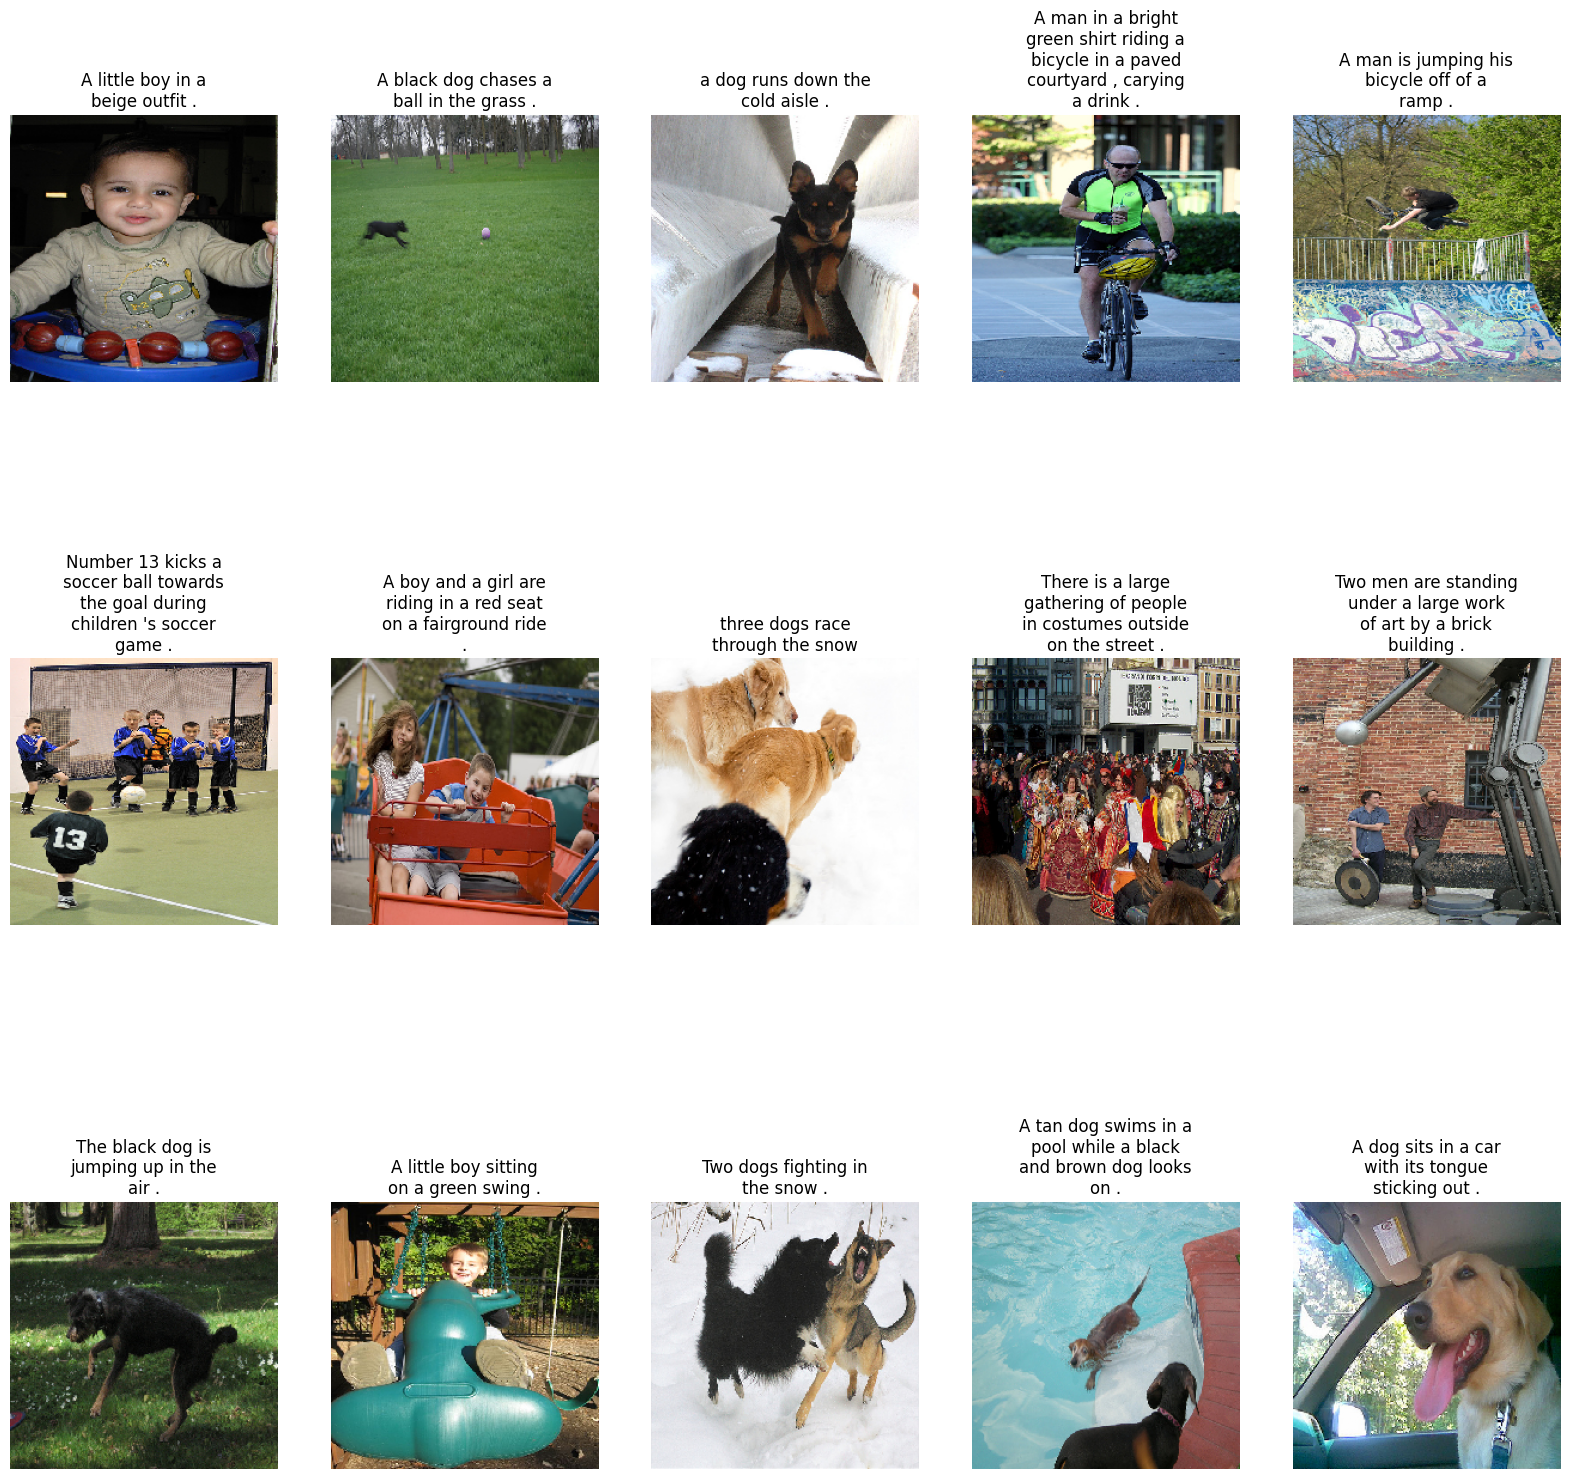

In [10]:
display_img(data.sample(15))

In [11]:
def preprocess_text(data):
    data["caption"] = data["caption"].apply(lambda x : x.lower())
    data["caption"] = data["caption"].apply(lambda x : x.replace("[^A-Za-z]",""))
    data["caption"] = data["caption"].apply(lambda x : x.replace("\s+", " "))
    data["caption"] = data["caption"].apply(lambda x : " ".join([word for word in x.split() if len(word) > 1]))
    data["caption"] = "Start " + data["caption"] + " end"
    return data

In [12]:
data = preprocess_text(data)
captions = data.caption.tolist()
captions[:10]

['Start child in pink dress is climbing up set of stairs in an entry way end',
 'Start girl going into wooden building end',
 'Start little girl climbing into wooden playhouse end',
 'Start little girl climbing the stairs to her playhouse end',
 'Start little girl in pink dress going into wooden cabin end',
 'Start black dog and spotted dog are fighting end',
 'Start black dog and tri-colored dog playing with each other on the road end',
 'Start black dog and white dog with brown spots are staring at each other in the street end',
 'Start two dogs of different breeds looking at each other on the road end',
 'Start two dogs on pavement moving toward each other end']

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence

In [14]:
token = Tokenizer()
token.fit_on_texts(captions)
vocab_size = len(token.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
images = data.image.unique().tolist()
n_images = len(images)
split_r = round(0.85*n_images)
train_sp = images[:split_r]
test_sp = images[split_r:]
train_data = data[data["image"].isin(train_sp)]
test_data = data[data["image"].isin(test_sp)]
train_data.reset_index(drop = True, inplace=True)
test_data.reset_index(drop = True, inplace=True)

In [15]:
from tensorflow.keras.applications import DenseNet201

In [16]:
model = DenseNet201()
D_net = tf.keras.Model(inputs = model.input, outputs = model.layers[-2].output)
img_size = 224
features = {}
for image in tqdm(data.image.unique().tolist()):
    img = load_img(os.path.join(img_path, image), target_size = (img_size, img_size))
    img = img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis = 0)
    feature = D_net.predict(img, verbose = 0)
    features[image] = feature

82524592/82524592 [==============================] - 0s 0us/step


100%|██████████| 8091/8091 [12:59<00:00, 10.38it/s]


In [17]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [18]:
input1 = tf.keras.Input(shape=(1920,))
input2 = tf.keras.Input(shape=(max_length,))

img_features = tf.keras.layers.Dense(256, activation='relu')(input1)
img_features_reshaped = tf.keras.layers.Reshape((1, 256), input_shape=(256,))(img_features)

sent_features = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = tf.keras.layers.concatenate([img_features_reshaped,sent_features],axis=1)
sentence_features = tf.keras.layers.LSTM(256)(merged)
x = tf.keras.layers.Dropout(0.5)(sentence_features)
x = tf.keras.layers.add([x, img_features])
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(vocab_size, activation='softmax')(x)

caption_model = tf.keras.Model(inputs=[input1,input2], outputs=output)

In [19]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [20]:
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [21]:
train_generator = CustomDataGenerator(df=train_data,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=token,vocab_size=vocab_size,max_length=max_length,features=features)

val_generator = CustomDataGenerator(df=test_data,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=token,vocab_size=vocab_size,max_length=max_length,features=features)

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("my_model.h5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

callbacks = [checkpoint, earlystopping, ReduceLR]

In [23]:
history = caption_model.fit(train_generator, epochs = 40, validation_data = val_generator, callbacks = callbacks)

Epoch 1/40
537/537 [==============================] - ETA: 0s - loss: 5.1150
Epoch 1: val_loss improved from inf to 4.21620, saving model to my_model.h5
537/537 [==============================] - 236s 428ms/step - loss: 5.1150 - val_loss: 4.2162 - lr: 0.0010
Epoch 2/40
537/537 [==============================] - ETA: 0s - loss: 4.1712
Epoch 2: val_loss improved from 4.21620 to 3.89511, saving model to my_model.h5
537/537 [==============================] - 59s 110ms/step - loss: 4.1712 - val_loss: 3.8951 - lr: 0.0010
Epoch 3/40
537/537 [==============================] - ETA: 0s - loss: 3.9070
Epoch 3: val_loss improved from 3.89511 to 3.76628, saving model to my_model.h5
537/537 [==============================] - 49s 90ms/step - loss: 3.9070 - val_loss: 3.7663 - lr: 0.0010
Epoch 4/40
537/537 [==============================] - ETA: 0s - loss: 3.7476
Epoch 4: val_loss improved from 3.76628 to 3.70131, saving model to my_model.h5
537/537 [==============================] - 50s 93ms/step - lo

In [24]:
def idx_to_word(integer, token):
    for word, index in token.word_index.items():
        if index == integer:
            return word
    return None

In [25]:
def predict_caption(model, image, token, max_length, features):

    feature = features[image]
    in_text = "Start"
    for i in range(max_length):
        sequence = token.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, token)

        if word is None:
            break

        in_text+= " " + word

        if word == 'end':
            break

    return in_text

In [35]:
samples = test_data.sample(15)
samples.reset_index(drop=True,inplace=True)

In [36]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(img_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], token, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 19ms/step


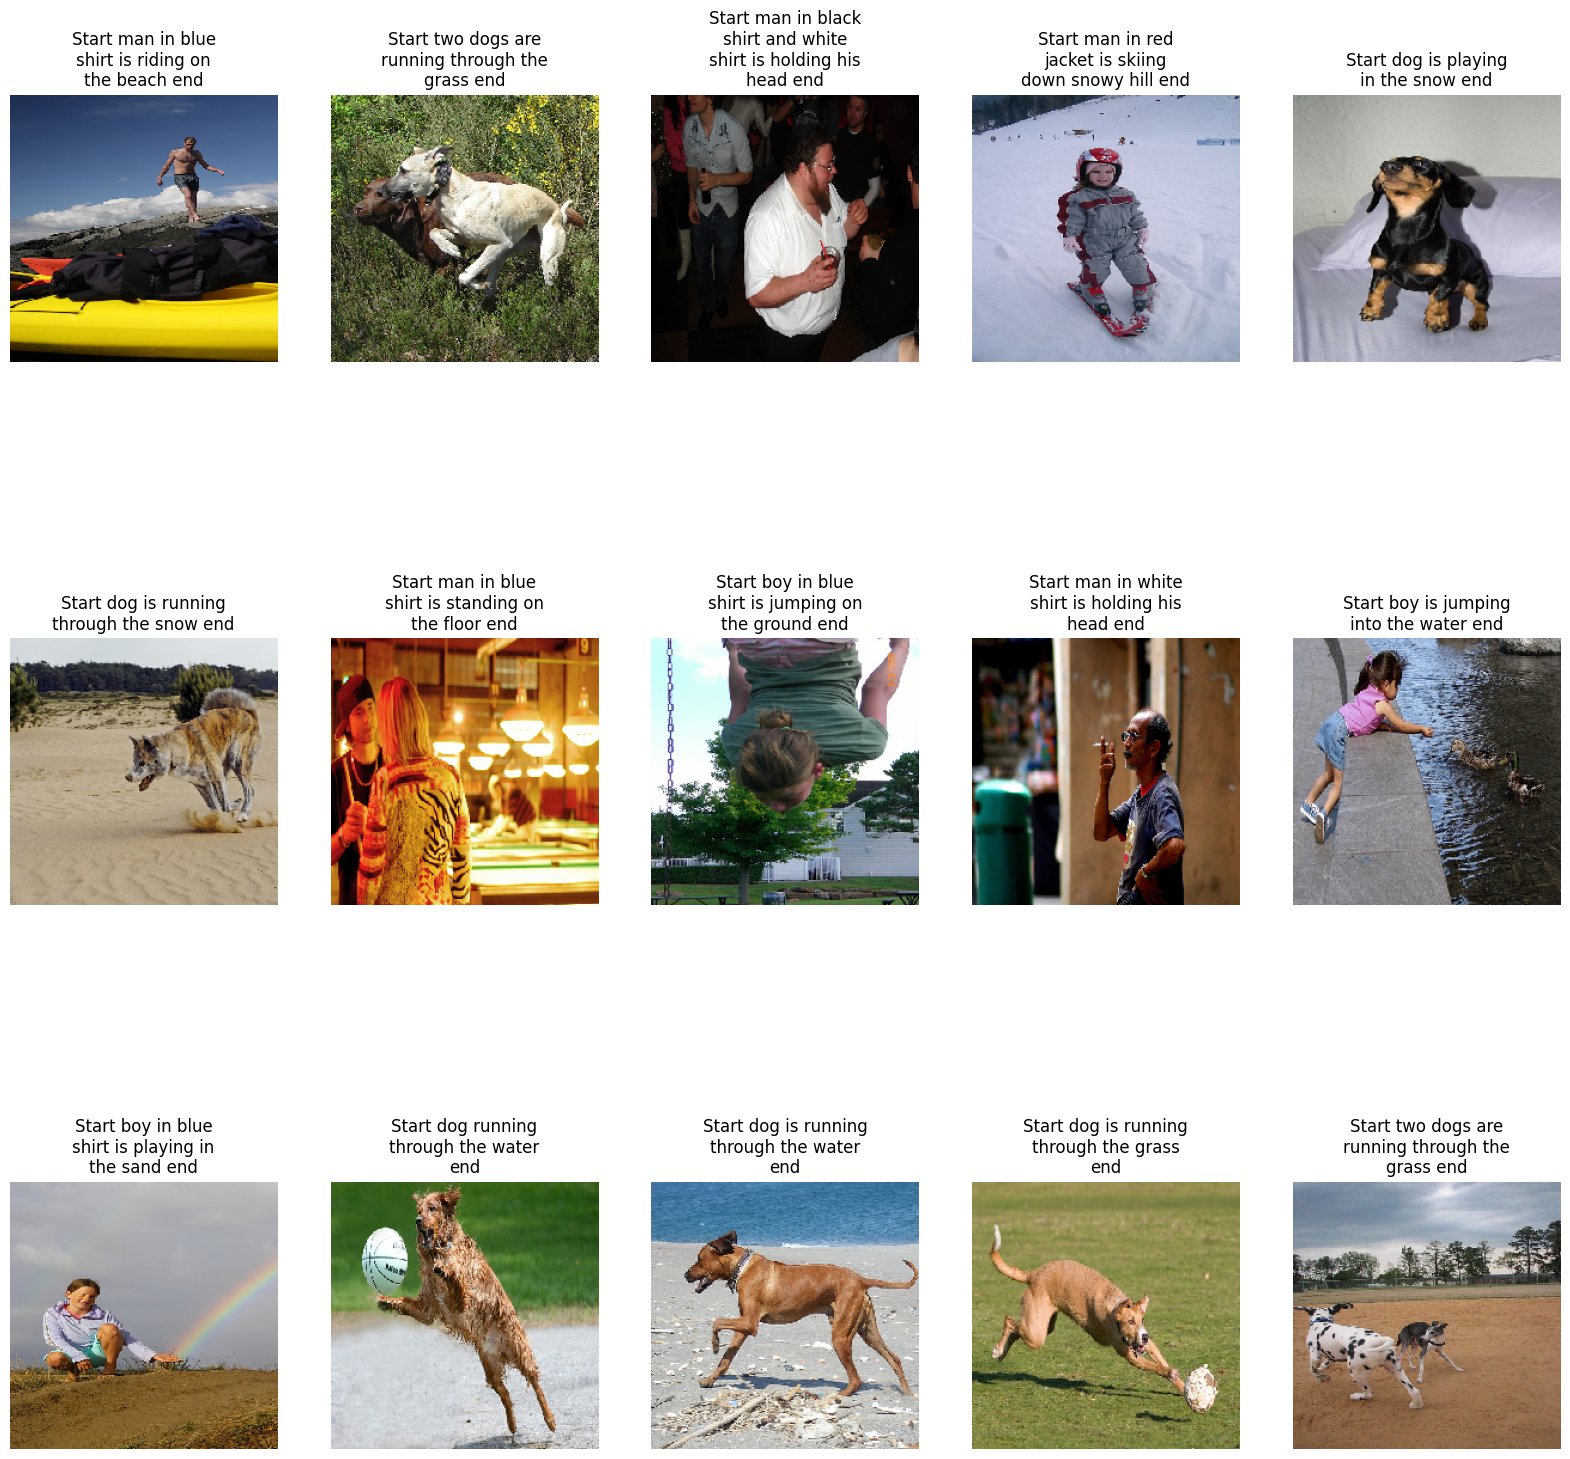

In [37]:
display_img(samples)